## Reinforcement Learning
### Chapter 5: Monte Carlo Methods
##### By Yurou He and Ruqing Xu   
##### Mar 6, 2025 

In [462]:
import sys
print(sys.executable)

/opt/anaconda3/bin/python


In [463]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

In [464]:
%matplotlib inline
print(os.getcwd())

/Users/yurouhe/Dropbox/PhD/2025 Spring/theory reading group/RLbook2020/python


### I. Introduction to Monte Carlo

#### Example: Estimating π Using the Monte Carlo Method

In [465]:
# Number of samples
num_samples = 1000000
inside_circle = 0

# Lists to store the points
x_inside, y_inside = [], []
x_outside, y_outside = [], []

# Monte Carlo simulation
for _ in range(num_samples):
    x, y = np.random.uniform(-1, 1, 2)  # Randomly sample in the range [-1,1]
    if x**2 + y**2 <= 1:  # Check if the point falls inside the unit circle
        inside_circle += 1
        x_inside.append(x)
        y_inside.append(y)
    else:
        x_outside.append(x)
        y_outside.append(y)

# Estimate pi
pi_estimate = 4 * inside_circle / num_samples
print(f"Monte Carlo estimated π value: {pi_estimate}")

Monte Carlo estimated π value: 3.144224


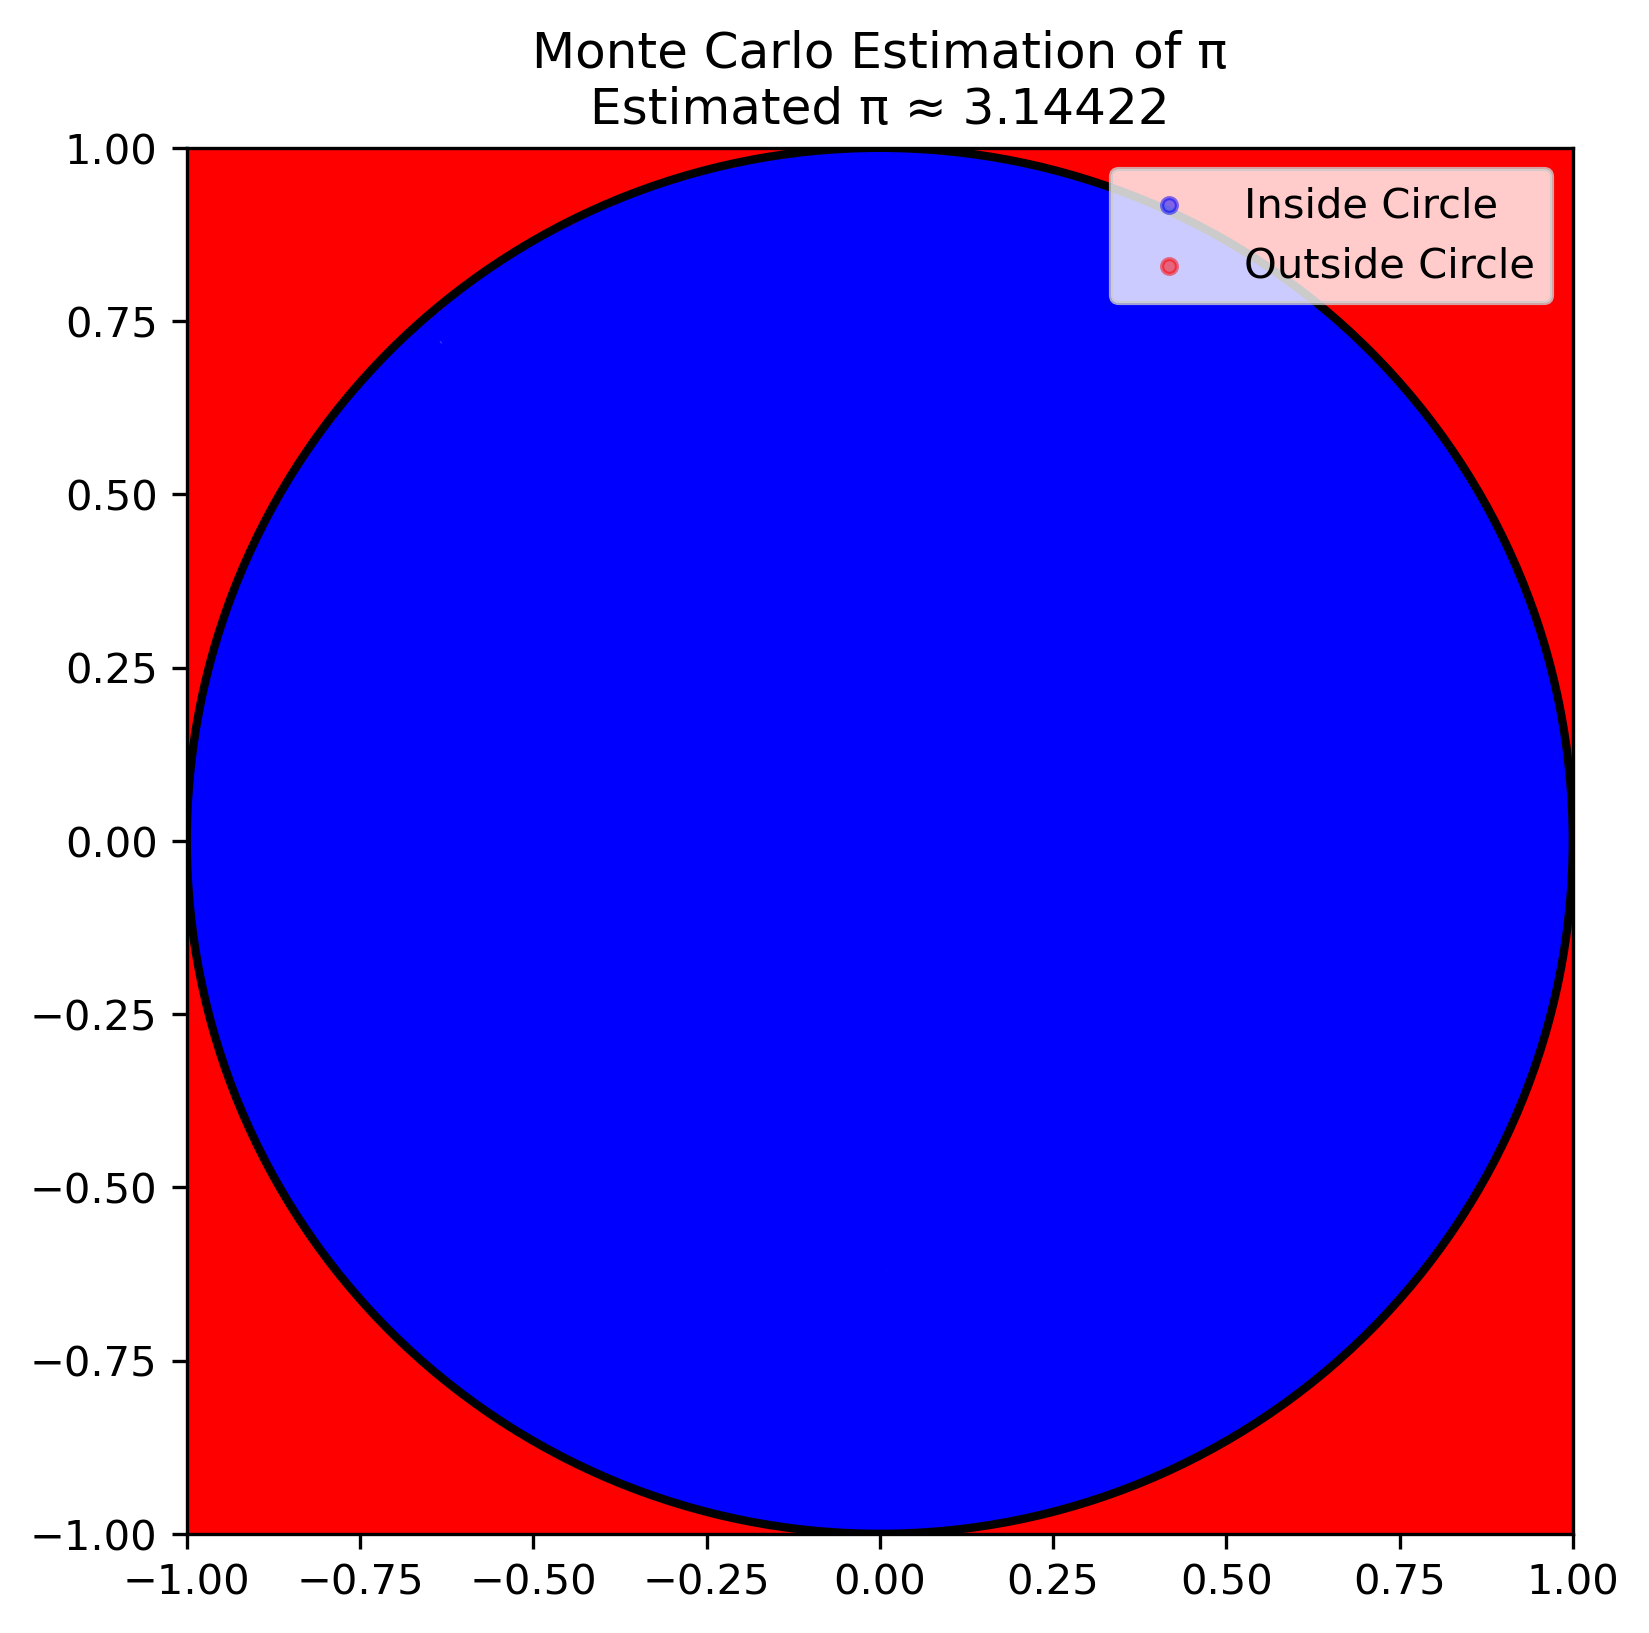

In [466]:
# Visualization
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)  # Higher DPI for better resolution
circle = plt.Circle((0, 0), 1, color='black', fill=False, linewidth=2)  # Unit circle

# Reduce marker size for better performance and visibility
ax.scatter(x_inside, y_inside, color='blue', s=0.5, label="Inside Circle", alpha=0.5)
ax.scatter(x_outside, y_outside, color='red', s=0.5, label="Outside Circle", alpha=0.5)
ax.add_patch(circle)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_aspect('equal')  # Equal aspect ratio
ax.set_title(f"Monte Carlo Estimation of π\nEstimated π ≈ {pi_estimate:.5f}")

# Manually place legend to avoid performance issues
ax.legend(loc="upper right", markerscale=5, fontsize=10, frameon=True)

# Save the figure
plt.savefig('images/figure_5_0_pi-estimate.png')
# Show the plot
plt.show()

### II. Example 5.1: Blackjack

#### Setup

In [467]:
# Actions: hit or stick
ACTION_HIT = 1
ACTION_STICK = 0
ACTIONS = [ACTION_HIT, ACTION_STICK]

In [468]:
# Dealer's policy
POLICY_DEALER = np.zeros(22, dtype=int)
POLICY_DEALER[0:16] = ACTION_HIT
POLICY_DEALER

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [469]:
# Player’s Policy
POLICY_PLAYER = np.zeros(22, dtype=int)
POLICY_PLAYER[0:12] = ACTION_HIT
POLICY_PLAYER

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [470]:
# function form of target policy of player
def target_policy_player(usable_ace_player, player_sum, dealer_card):
    return POLICY_PLAYER[player_sum]

In [471]:
# get a new card
def get_card():
    card = np.random.randint(1, 14)
    card = min(card, 10)
    return card

# get the value of a card (11 for ace).
def card_value(card_id):
    return 11 if card_id == 1 else card_id

In [472]:
# play a game
# @policy_player: specify policy for player
# @initial_state: [whether player has a usable Ace, sum of player's cards, one card of dealer]
# @initial_action: the initial action
def play(policy_player, initial_state=None, initial_action=None):

    # i. Player's Status -----

    # sum of player
    player_sum = 0

    # trajectory of player
    player_trajectory = []

    # whether player uses Ace as 11
    usable_ace_player = False

    # dealer status
    dealer_card1 = 0
    dealer_card2 = 0
    usable_ace_dealer = False

    if initial_state is None:

        # generate a random initial state
        while player_sum < 12:
            
            # if sum of player is less than 12, always hit
            card = get_card()
            player_sum += card_value(card)

            # If the player's sum is larger than 21, he may hold one or two aces.
            if player_sum > 21:
                assert player_sum == 22 # ensures the only possible case is 22
                player_sum -= 10 # last card must be ace
            else:
                usable_ace_player |= (1 == card)

        # initialize cards of dealer, suppose dealer will show the first card he gets
        dealer_card1 = get_card()
        dealer_card2 = get_card()
    else:
        # use specified initial state
        usable_ace_player, player_sum, dealer_card1 = initial_state
        dealer_card2 = get_card()

    # initial state of the game
    state = [usable_ace_player, player_sum, dealer_card1]

    # ii. Dealer's Status -----
    # initialize dealer's sum
    dealer_sum = card_value(dealer_card1) + card_value(dealer_card2)
    usable_ace_dealer = 1 in (dealer_card1, dealer_card2)

    # if the dealer's sum is larger than 21, he must hold two aces.
    if dealer_sum > 21:
        assert dealer_sum == 22
        dealer_sum -= 10 # use one Ace as 1 rather than 11

    assert dealer_sum <= 21
    assert player_sum <= 21

    # iii. Game Starts! -----

    # A. Player's turn
    while True:
        if initial_action is not None:
            action = initial_action
            initial_action = None
        else:
            # get action based on current sum
            action = policy_player(usable_ace_player, player_sum, dealer_card1)

        # track player's trajectory for importance sampling
        player_trajectory.append([(usable_ace_player, player_sum, dealer_card1), action])

        if action == ACTION_STICK:
            break
        # if hit, get new card
        card = get_card()
        # Keep track of the ace count. the usable_ace_player flag is insufficient alone as it cannot
        # distinguish between having one ace or two.
        ace_count = int(usable_ace_player)
        if card == 1:
            ace_count += 1
        player_sum += card_value(card)
        # If the player has a usable ace, use it as 1 to avoid busting and continue.
        while player_sum > 21 and ace_count:
            player_sum -= 10
            ace_count -= 1
        # player busts
        if player_sum > 21:
            return state, -1, player_trajectory
        assert player_sum <= 21
        usable_ace_player = (ace_count == 1)

    # B. Dealer's turn
    while True:
        # get action based on current sum
        action = POLICY_DEALER[dealer_sum]
        if action == ACTION_STICK:
            break
        # if hit, get a new card
        new_card = get_card()
        ace_count = int(usable_ace_dealer)
        if new_card == 1:
            ace_count += 1
        dealer_sum += card_value(new_card)
        # If the dealer has a usable ace, use it as 1 to avoid busting and continue.
        while dealer_sum > 21 and ace_count:
            dealer_sum -= 10
            ace_count -= 1
        # dealer busts
        if dealer_sum > 21:
            return state, 1, player_trajectory
        usable_ace_dealer = (ace_count == 1)

    # compare the sum between player and dealer
    assert player_sum <= 21 and dealer_sum <= 21
    if player_sum > dealer_sum:
        return state, 1, player_trajectory
    elif player_sum == dealer_sum:
        return state, 0, player_trajectory
    else:
        return state, -1, player_trajectory
    
    # Output: (state, reward, trajectory)

#### Part 1. Monte Carlo Evaluation (Fixed Policy)

In [473]:
# Monte Carlo Sample with On-Policy
def monte_carlo_on_policy(episodes):

    # states: (playerSum, dealerCard, usableAce)
    states_usable_ace = np.zeros((10, 10))
    states_usable_ace_count = np.ones((10, 10)) # initialze counts to 1 to avoid 0 being divided
    
    states_no_usable_ace = np.zeros((10, 10)) 
    states_no_usable_ace_count = np.ones((10, 10)) # initialze counts to 1 to avoid 0 being divided

    for i in tqdm(range(0, episodes)):
        _, reward, player_trajectory = play(target_policy_player)
        for (usable_ace, player_sum, dealer_card), _ in player_trajectory:
            player_sum -= 12
            dealer_card -= 1
            if usable_ace:
                states_usable_ace_count[player_sum, dealer_card] += 1
                states_usable_ace[player_sum, dealer_card] += reward
            else:
                states_no_usable_ace_count[player_sum, dealer_card] += 1
                states_no_usable_ace[player_sum, dealer_card] += reward
    return states_usable_ace / states_usable_ace_count, states_no_usable_ace / states_no_usable_ace_count


100%|██████████| 500000/500000 [00:05<00:00, 95706.11it/s]


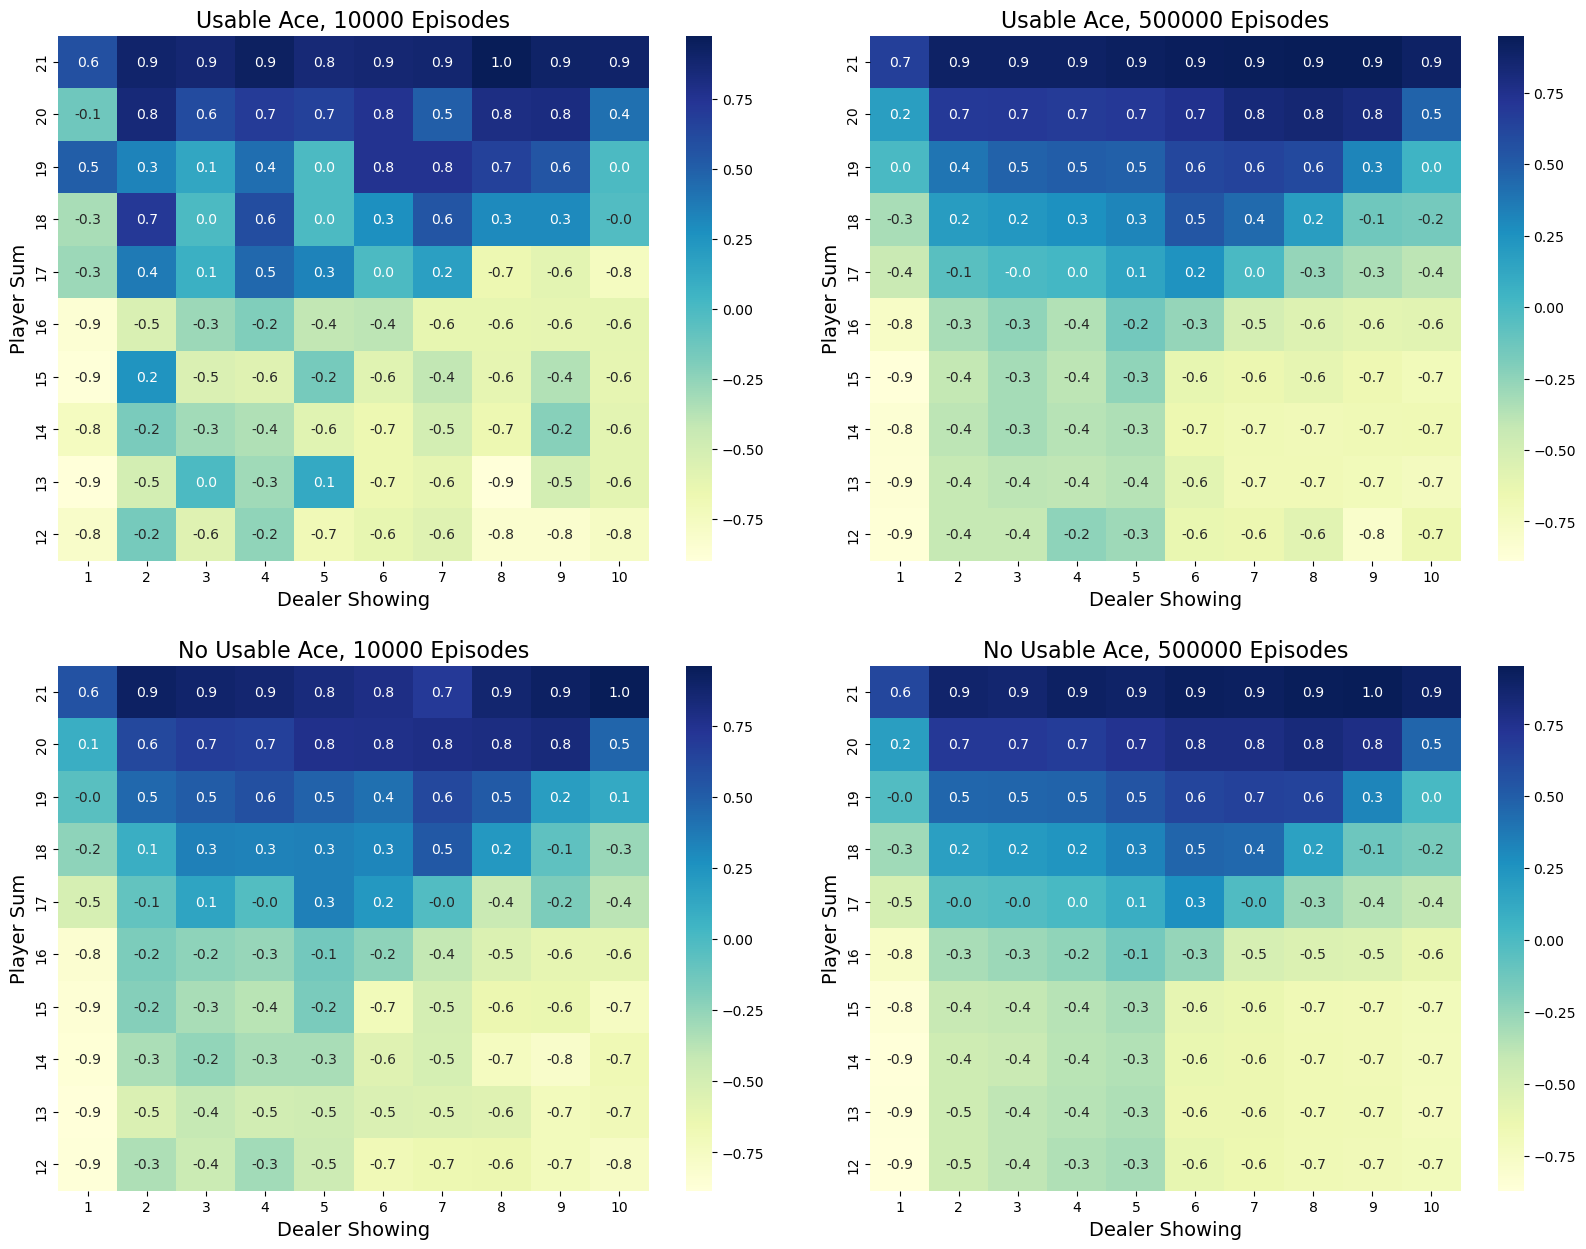

In [474]:
def figure_5_1():
    states_usable_ace_1, states_no_usable_ace_1 = monte_carlo_on_policy(10000)
    states_usable_ace_2, states_no_usable_ace_2 = monte_carlo_on_policy(500000)

    states = [states_usable_ace_1,
              states_usable_ace_2,
              states_no_usable_ace_1,
              states_no_usable_ace_2]

    titles = ['Usable Ace, 10000 Episodes',
              'Usable Ace, 500000 Episodes',
              'No Usable Ace, 10000 Episodes',
              'No Usable Ace, 500000 Episodes']

    _, axes = plt.subplots(2, 2, figsize=(20, 15))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    axes = axes.flatten()

    for state, title, axis in zip(states, titles, axes):
        sns.heatmap(np.flipud(state), cmap="YlGnBu", ax=axis, 
                    xticklabels=range(1, 11),
                    yticklabels=list(reversed(range(12, 22))),
                    annot=True, fmt=".1f")
        axis.set_ylabel('Player Sum', fontsize=14)
        axis.set_xlabel('Dealer Showing', fontsize=14)
        axis.set_title(title, fontsize=16)

    # Create the directory explicitly
    os.makedirs('./images', exist_ok=True)

    # Save explicitly to the known location
    plt.savefig('./images/figure_5_1.png', bbox_inches='tight')
    
    # Display plot inline
    plt.show()

    # Explicitly close figure
    plt.close()

# Run function
figure_5_1()

#### Part 2. Monte Carlo with Exploring Starts

In [475]:
# Monte Carlo with Exploring Starts
def monte_carlo_es(episodes):
    
    # (playerSum, dealerCard, usableAce, action)
    state_action_values = np.zeros((10, 10, 2, 2))
    # initialze counts to 1 to avoid division by 0
    state_action_pair_count = np.ones((10, 10, 2, 2))

    # Greedy behavior policy
    def behavior_policy(usable_ace, player_sum, dealer_card):
        usable_ace = int(usable_ace)
        player_sum -= 12 # (12-21) -> (0,9)
        dealer_card -= 1 # (1-10) -> (0,9)

        # get argmax of the average returns Q-values = (s, a)
        values_ = state_action_values[player_sum, dealer_card, usable_ace, :] / \
                  state_action_pair_count[player_sum, dealer_card, usable_ace, :]
        return np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

    # play for several episodes
    for episode in tqdm(range(episodes)):
        # for each episode, use a randomly initialized state and action
        initial_state = [bool(np.random.choice([0, 1])),
                       np.random.choice(range(12, 22)),
                       np.random.choice(range(1, 11))]
        initial_action = np.random.choice(ACTIONS)
        current_policy = behavior_policy if episode else target_policy_player
        _, reward, trajectory = play(current_policy, initial_state, initial_action)

        # First-Visit MC ensures that each state-action pair is updated based only on
        # The first time it was visited in a given episode
        # Making the learning process more stable
        first_visit_check = set()
        for (usable_ace, player_sum, dealer_card), action in trajectory:
            usable_ace = int(usable_ace)
            player_sum -= 12
            dealer_card -= 1
            state_action = (usable_ace, player_sum, dealer_card, action)
            if state_action in first_visit_check:
                continue
            first_visit_check.add(state_action)
            # update values of state-action pairs
            state_action_values[player_sum, dealer_card, usable_ace, action] += reward
            state_action_pair_count[player_sum, dealer_card, usable_ace, action] += 1

    return state_action_values / state_action_pair_count

100%|██████████| 500000/500000 [00:18<00:00, 26798.45it/s]


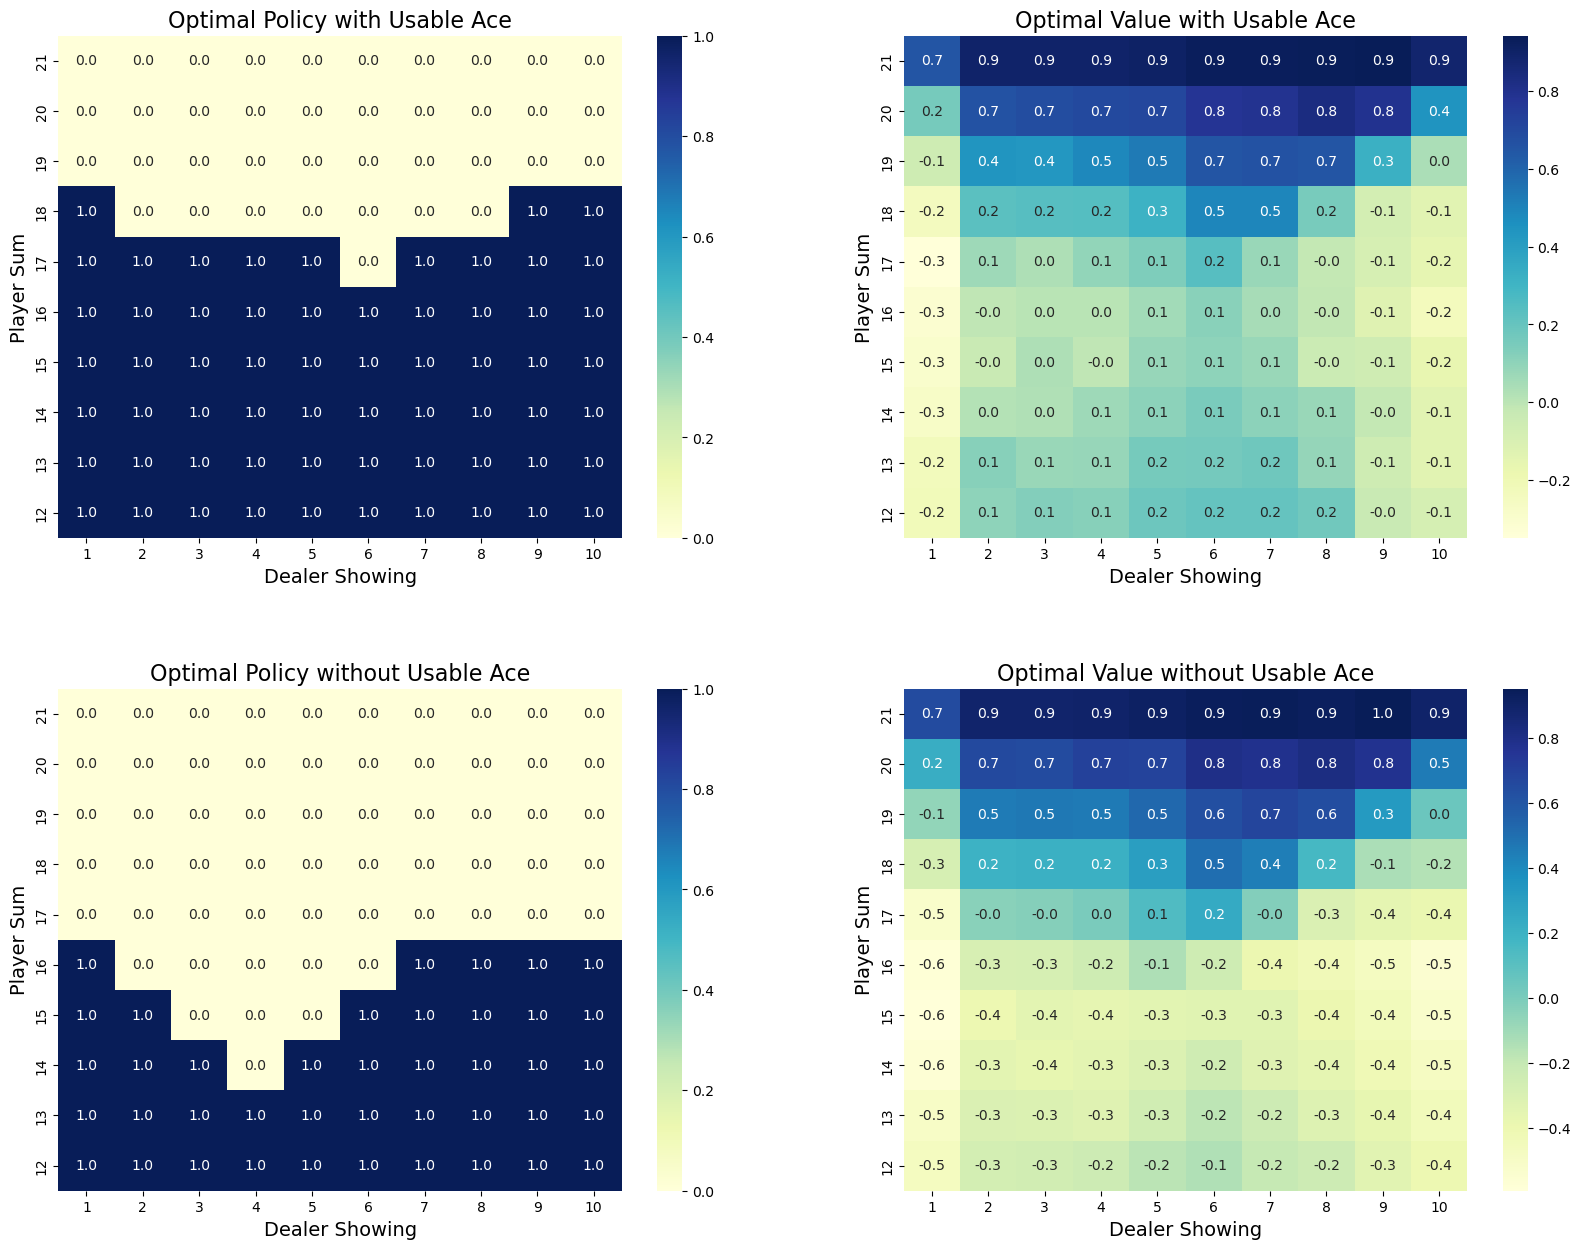

In [476]:
def figure_5_2():

    state_action_values = monte_carlo_es(500000)

    # Get Q-values
    state_value_no_usable_ace = np.max(state_action_values[:, :, 0, :], axis=-1)
    state_value_usable_ace = np.max(state_action_values[:, :, 1, :], axis=-1)

    # Get the optimal policy
    action_no_usable_ace = np.argmax(state_action_values[:, :, 0, :], axis=-1)
    action_usable_ace = np.argmax(state_action_values[:, :, 1, :], axis=-1)

    images = [action_usable_ace,
              state_value_usable_ace,
              action_no_usable_ace,
              state_value_no_usable_ace]

    titles = ['Optimal Policy with Usable Ace',
              'Optimal Value with Usable Ace',
              'Optimal Policy without Usable Ace',
              'Optimal Value without Usable Ace']

    _, axes = plt.subplots(2, 2, figsize=(20, 15))
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    axes = axes.flatten()

    for image, title, axis in zip(images, titles, axes):
        sns.heatmap(np.flipud(image), cmap="YlGnBu", ax=axis,
                    xticklabels=range(1, 11),
                    yticklabels=list(reversed(range(12, 22))),
                    annot=True, fmt=".1f")
        axis.set_ylabel('Player Sum', fontsize=14)
        axis.set_xlabel('Dealer Showing', fontsize=14)
        axis.set_title(title, fontsize=16)

    os.makedirs('images', exist_ok=True)
    plt.savefig('images/figure_5_2.png', bbox_inches='tight')

    plt.show()
    plt.close()

figure_5_2()

#### Part 3. Off-Policy Monte Carlo Prediction

In [477]:
# function form of behavior policy of player (off-policy learning)
def behavior_policy_player(usable_ace_player, player_sum, dealer_card):
    if np.random.binomial(1, 0.5) == 1:
        return ACTION_STICK
    return ACTION_HIT

In [478]:
# Monte Carlo Sample with Off-Policy
def monte_carlo_off_policy(episodes):
    initial_state = [True, 13, 2]

    rhos = []
    returns = []

    for i in range(0, episodes):
        _, reward, player_trajectory = play(behavior_policy_player, initial_state=initial_state)

        # get the importance ratio
        numerator = 1.0
        denominator = 1.0
        for (usable_ace, player_sum, dealer_card), action in player_trajectory:
            if action == target_policy_player(usable_ace, player_sum, dealer_card):
                denominator *= 0.5
            else:
                numerator = 0.0
                break
        rho = numerator / denominator
        rhos.append(rho)
        returns.append(reward)

    # Get results
    rhos = np.asarray(rhos)
    returns = np.asarray(returns)

    # Compute weights for weighted sampling
    weighted_returns = rhos * returns
    weighted_returns = np.add.accumulate(weighted_returns)

    # Compute rho value
    rhos = np.add.accumulate(rhos)

    # Ordinary Sampling
    ordinary_sampling = weighted_returns / np.arange(1, episodes + 1)

    # Weighted Sampling
    with np.errstate(divide='ignore',invalid='ignore'):
        weighted_sampling = np.where(rhos != 0, weighted_returns / rhos, 0)

    return ordinary_sampling, weighted_sampling

Running simulations: 100%|██████████| 100/100 [00:08<00:00, 12.31it/s]


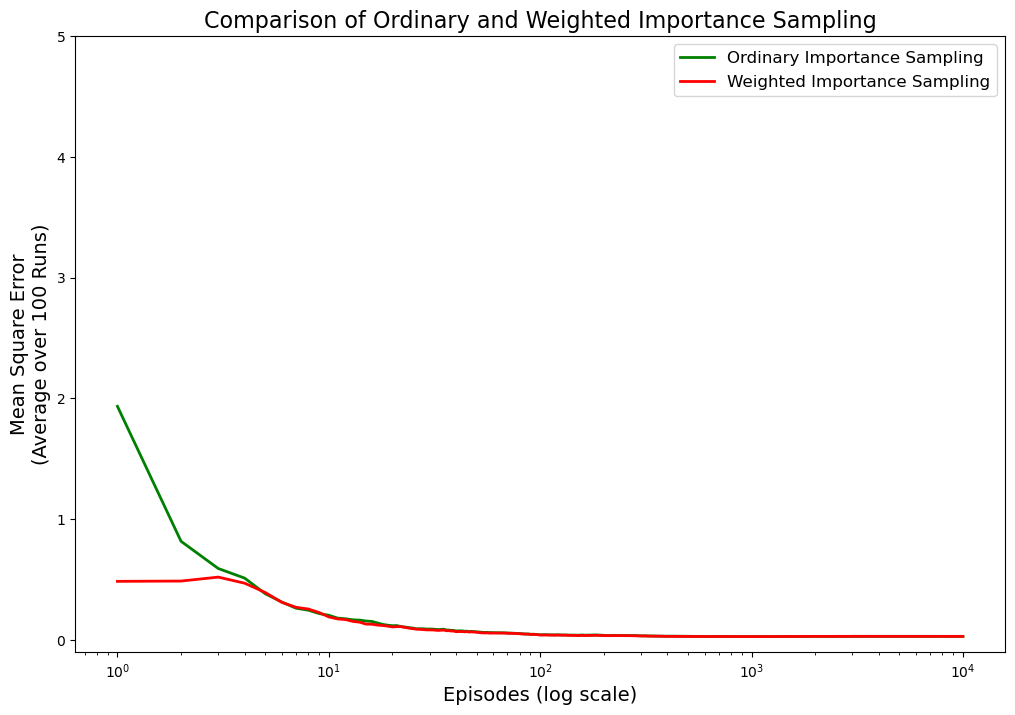

In [479]:
def figure_5_3():
    true_value = -0.27726
    episodes = 10000
    runs = 100
    error_ordinary = np.zeros(episodes)
    error_weighted = np.zeros(episodes)

    for _ in tqdm(range(runs), desc='Running simulations'):
        ordinary_sampling, weighted_sampling = monte_carlo_off_policy(episodes)
        error_ordinary += (ordinary_sampling - true_value) ** 2
        error_weighted += (weighted_sampling - true_value) ** 2

    error_ordinary /= runs
    error_weighted /= runs

    plt.figure(figsize=(12, 8))
    plt.plot(np.arange(1, episodes + 1), error_ordinary, color='green', label='Ordinary Importance Sampling', linewidth=2)
    plt.plot(np.arange(1, episodes + 1), error_weighted, color='red', label='Weighted Importance Sampling', linewidth=2)

    plt.ylim(-0.1, 5)
    plt.xlabel('Episodes (log scale)', fontsize=14)
    plt.ylabel(f'Mean Square Error\n(Average over {runs} Runs)', fontsize=14)
    plt.xscale('log')
    plt.title('Comparison of Ordinary and Weighted Importance Sampling', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(False)

    os.makedirs('images', exist_ok=True)
    plt.savefig('images/figure_5_3.png', bbox_inches='tight')

    plt.show()
    plt.close()

figure_5_3()

### III. Example 5.2: Infinite Variance

#### Setup

In [480]:
ACTION_BACK = 0
ACTION_END = 1

In [481]:
# behavior policy
def behavior_policy():
    return np.random.binomial(1, 0.5)

# target policy
def target_policy():
    return ACTION_BACK

In [482]:
# one turn
def play():
    # track the action for importance ratio
    trajectory = []
    while True:
        action = behavior_policy()
        trajectory.append(action)
        if action == ACTION_END:
            return 0, trajectory
        if np.random.binomial(1, 0.9) == 0:
            return 1, trajectory

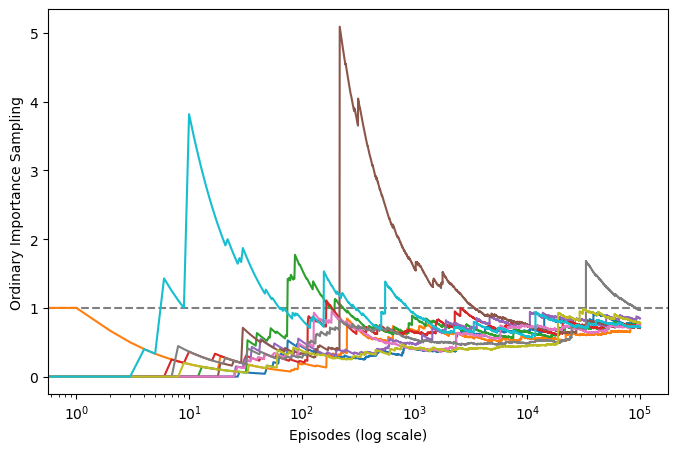

In [483]:
def figure_5_4():
    runs = 10
    episodes = 100000
    plt.figure(figsize=(8, 5))
    plt.axhline(y=1, color='gray', linestyle='dashed', linewidth=1.5)
    for run in range(runs):
        rewards = []
        for episode in range(0, episodes):
            reward, trajectory = play()
            if trajectory[-1] == ACTION_END:
                rho = 0
            else:
                rho = 1.0 / pow(0.5, len(trajectory))
            rewards.append(rho * reward)
        rewards = np.add.accumulate(rewards)
        estimations = np.asarray(rewards) / np.arange(1, episodes + 1)
        plt.plot(estimations)
    plt.xlabel('Episodes (log scale)')
    plt.ylabel('Ordinary Importance Sampling')
    plt.xscale('log')
    

    plt.savefig('images/figure_5_4.png', bbox_inches='tight')
    plt.show()

figure_5_4()